# Discrete Regression

Here we consider *discrete* dependent variables: binary outcomes, variables taking positive integer values. For details and examples read [here](https://www.kellogg.northwestern.edu/faculty/dranove/htm/dranove/coursepages/Mgmt%20469/discrete-lhs.pdf).

Linear regression requires that the dependent(response) variable is a normal-distributed *continuous* variable and thus cannot be used directly for discrete dependent variables.

However, it is possible to map a linear predictor to an interval that can be considered as a *probability* of discrete outcome.  

In a bit more detail:
* We want to estimate the probability ($p$) of observing $y$ given the value of the independent variable $x$.  
* Simply fitting a linear model will in general fail since probabilities must be positive and sum to one.
* So we need a non-linear model, but we already know this can be hard.
* However, instead of fitting the probability directly, we use a linear model to fit a known non-linear function of the probability.  Once this function is fitted, we can then compute the probability.

The `statsmodels` library has several classes for handling discrete regression:
- `Logit` : binary choice logit model (we'll use this below)
- `Probit`: binary choice Probit model uses a cumulative distribution function of the normal distribution (the error function or `erf`) instead of the logistic function, but is in spirit very similar to `Logit`
- `MNLogit`: multinomial logistic regression (for more than 2 categories) 
- `Poisson`: Possion regression (for count data)

For more detail, see http://www.statsmodels.org/dev/discretemod.html and https://www.statsmodels.org/stable/index.html 



In [1]:
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg
import patsy
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats

For binary outcomes, a popular map is the logistic function 
$$
\log \frac{p}{1-p}
$$
where $p$ is the probability of an outcome.  

We will fit this function of the probability to a linear model, i.e., 
$$
\log \frac{p}{1-p}  = \beta_0 + \beta_1 x
$$
where $\beta_0$ and $\beta_1$ are the model parameters, and $x$ is the independent variable(s).

*Note* that the right hand side is *linear* in the parameters $\beta_0$ and $\beta_1$ so we can use linear regression to fit $\log \frac{p}{1-p}$.  Once we have fitted this, we can rearrange to compute the probability with 
$$
     p(x) = \frac{1}{1+exp(-\beta_0 - \beta_1 x)}.
$$
* This is called the logistic (or sigmoid) function.
* It maps $x \in [-\infty, \infty]$ to $ p \in [0,1] $.
* It takes the value $p=0.5$ at $x=-\frac{\beta_0}{\beta_1}$.
* The rate of switching (sharpness of classification) is controlled by $\beta_1$.

To make a binary classifier that selects between $y = 0,1$
* If $p<0.5$, we predict that $y=0$, and
* If $p\geq 0.5$, we predict that $y=1$.   

Play with $\beta_0$ and $\beta_1$ below to get some intuition about what is going in.
* Smaller beta1 means slower switching and hence less sharp classification
* Large beta1 means faster switching and hence sharper classification

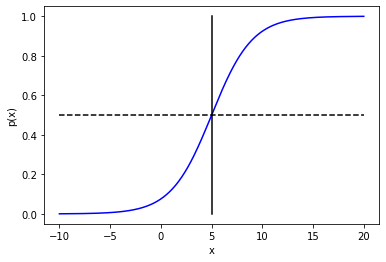

In [2]:
# Given beta0 and beta1 plot the logistic function 

beta1 = 0.5 # Try adjusting the rate of switching from 0.1 to 10
beta0 = -5.0*beta1 # Change x position
xhalf = -beta0/beta1
x = np.linspace(-10,20,300)
p = 1.0/(1.0+np.exp(-beta0 - beta1*x))
# Plot the logistic function along with lines to mark the transition point
plt.plot(x,p,"b-",[xhalf,xhalf], [0,1], "k",[-10,20],[0.5,0.5],"k--")
plt.xlabel("x")
plt.ylabel("p(x)")
plt.show()

In [ ]:
#to check version of Statmodels
#sm.show_versions()

## Logistic Regression

[Logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) is an important *machine-learning* technique estimates the parameters for a binary classification model that assigns a probability score to select between two possible outcomes.

Briefly review Wikipedia page (above link).

Advantages:
* doesn’t require high computational power
* easily interpretable
* widely used
* easy to implement
* doesn’t require scaling of features
* provides a probability score for observations.

Disadvantages:
* cannot handle a large number of categorical features/variables
* vulnerable to overfitting
* cannot solve a non-linear problem with the logistic regression model (must first transform them)
* will not perform well with independent (X) variables that are not correlated to the target(Y) variable.


**Example:** We will load a dataset which contains sepal and petal lengths and widths for a sample of [Iris flowers](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html) and a classification of the species of the flower.

<img src="https://drive.google.com/uc?id=1vt_4kXCaIPTiTkA7nQzdnXhg792MZHUi" width="400">

In [3]:
# load the "iris" dataset 
df = sm.datasets.get_rdataset("iris").data

In [4]:
# look at the info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Sepal.Length  150 non-null    float64
 1   Sepal.Width   150 non-null    float64
 2   Petal.Length  150 non-null    float64
 3   Petal.Width   150 non-null    float64
 4   Species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [5]:
# look at the data
df

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [6]:
# How many unique types of species in the Species column
df.Species.unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

There are 3 species. 

To get a binary variable, we will choose 2 species: 'versicolor', 'virginica'

In [7]:
# extract subset
df_subset = df[(df.Species=="versicolor") | (df.Species=="virginica")].copy()

In [8]:
# look at info
df_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 50 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Sepal.Length  100 non-null    float64
 1   Sepal.Width   100 non-null    float64
 2   Petal.Length  100 non-null    float64
 3   Petal.Width   100 non-null    float64
 4   Species       100 non-null    object 
dtypes: float64(4), object(1)
memory usage: 4.7+ KB


In [9]:
# look at data
df_subset

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
50,7.0,3.2,4.7,1.4,versicolor
51,6.4,3.2,4.5,1.5,versicolor
52,6.9,3.1,4.9,1.5,versicolor
53,5.5,2.3,4.0,1.3,versicolor
54,6.5,2.8,4.6,1.5,versicolor
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


We are doing binary classification so we must choose one species to be 0 and the other to be 1
* Versicolor --- 1
* Virginica --- 0

Replace the text species label with the integer label

In [10]:
# map the two species names into binary values 0 and 1
# !!! Don't execute this cell twice ... if you do you will see NaN
# and must reload the data and reexecute everything down to here

df_subset.Species = df_subset.Species.map({"versicolor":1, "virginica":0})
df_subset

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
50,7.0,3.2,4.7,1.4,1
51,6.4,3.2,4.5,1.5,1
52,6.9,3.1,4.9,1.5,1
53,5.5,2.3,4.0,1.3,1
54,6.5,2.8,4.6,1.5,1
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,0
146,6.3,2.5,5.0,1.9,0
147,6.5,3.0,5.2,2.0,0
148,6.2,3.4,5.4,2.3,0


The dot (".") in the column names means we cannot use the column name as an accessor for the data
(and hence breaks Patsy)

In [11]:
df_subset.Sepal.Length

AttributeError: 'DataFrame' object has no attribute 'Sepal'

So we replace the "." with an "_"

In [13]:
# Replace " . " in column names with " _ "
df_subset.rename(columns={"Sepal.Length": "Sepal_Length", "Sepal.Width": "Sepal_Width",
                          "Petal.Length": "Petal_Length", "Petal.Width": "Petal_Width"}, inplace=True) # On the existing dataset

In [14]:
# Illustrate use of accessor, note the name is case sensitive
df_subset.Sepal_Length

50     7.0
51     6.4
52     6.9
53     5.5
54     6.5
      ... 
145    6.7
146    6.3
147    6.5
148    6.2
149    5.9
Name: Sepal_Length, Length: 100, dtype: float64

In [15]:
# now we have a DataFrame object that is ready for use for analysis
df_subset

,Sepal_Length,Sepal_Width,Petal_Length,Petal_Width,Species
50,7.0,3.2,4.7,1.4,1
51,6.4,3.2,4.5,1.5,1
52,6.9,3.1,4.9,1.5,1
53,5.5,2.3,4.0,1.3,1
54,6.5,2.8,4.6,1.5,1
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,0
146,6.3,2.5,5.0,1.9,0
147,6.5,3.0,5.2,2.0,0
148,6.2,3.4,5.4,2.3,0


Let's look at the data visually trying to see which variables correlate strongly with outcome

There are 16 possible combinations of our data.


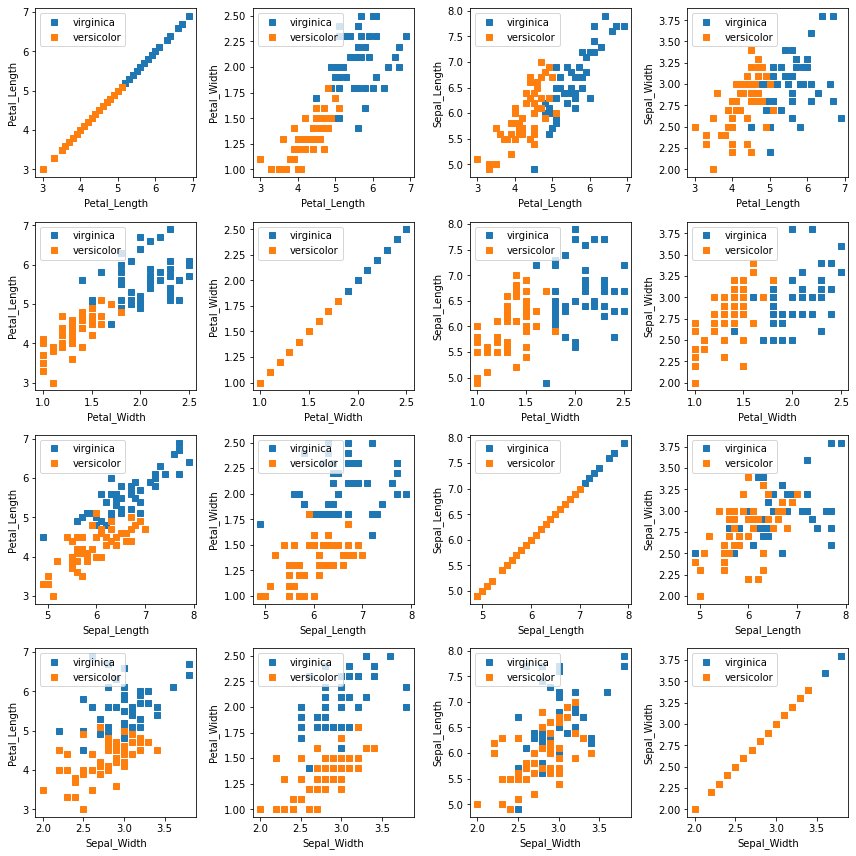

In [16]:
names = ["Petal_Length","Petal_Width","Sepal_Length", "Sepal_Width"]
data0 = [df_subset[df_subset.Species == 0][name].values for name in names]
data1 = [df_subset[df_subset.Species == 1][name].values for name in names]

fig = plt.figure(figsize=(12,12))
count = 1
for i in range(len(names)):
    for j in range(len(names)):
        ax = fig.add_subplot(4,4,count)
        ax.plot(data0[i],data0[j],'s', label='virginica')
        ax.plot(data1[i],data1[j],'s', label='versicolor')
        ax.set_xlabel(names[i])
        ax.set_ylabel(names[j])
        ax.legend(loc=2)
        count += 1
fig.tight_layout()

Wow --- look at the diagonal plots --- perfect separation seems possible!
* But why are there so few virginica points?  E.g., look at the off diagonal plots. 
* What's going on?

Recall the mantras "guilty until proved innocent" and "too good to be true."

Redo the plot but change the markers for data2 to '.'.

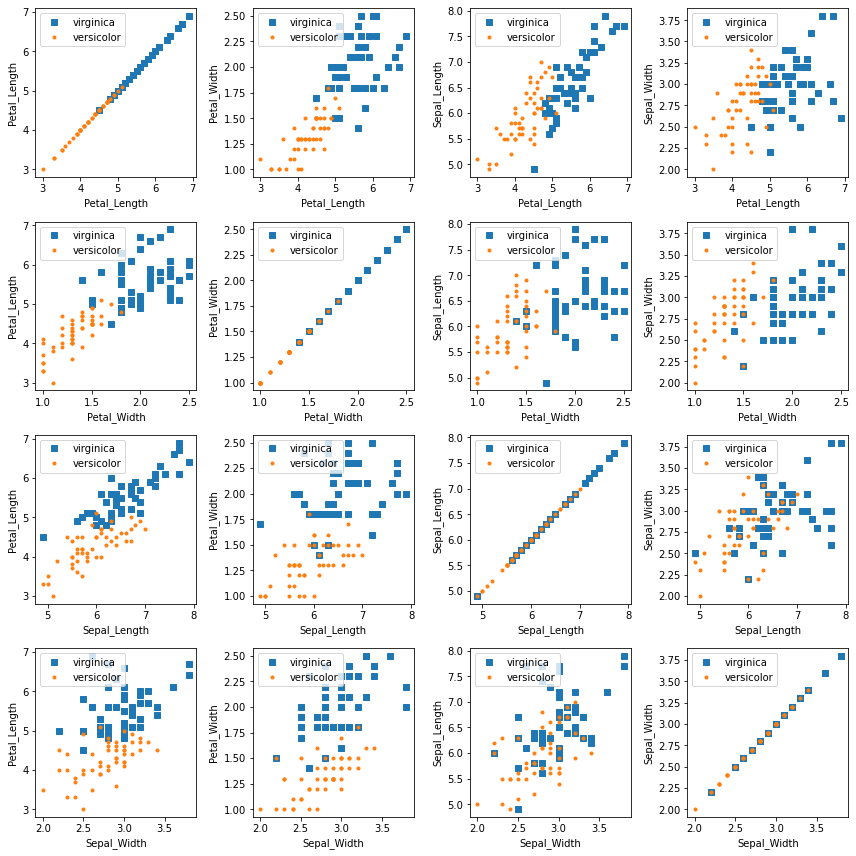

In [17]:
fig = plt.figure(figsize=(12,12))
count = 1
for i in range(len(names)):
    for j in range(len(names)):
        ax = fig.add_subplot(4,4,count)
        ax.plot(data0[i],data0[j],'s', label='virginica')
        ax.plot(data1[i],data1[j],'.', label='versicolor')
        ax.set_xlabel(names[i])
        ax.set_ylabel(names[j])
        ax.legend(loc=2)
        count += 1
fig.tight_layout()

What's the moral? 
* Be very careful with plots --- they can easily mislead
* Keep asking questions to support your conclusions
* Even "correct" programs can produce "incorrect" results

Now we can do a logistic regression analysis.

Documentation is [here](https://www.statsmodels.org/stable/generated/statsmodels.formula.api.logit.html#statsmodels.formula.api.logit)

We start off trying to use all four measures

In [18]:
# Create an instance of the smf.logit class with a Patsy formula 
model = smf.logit("Species ~ Sepal_Length + Sepal_Width + Petal_Length + Petal_Width"
                 , data = df_subset)

In [19]:
# Use the fit method to fit the model
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.059493
         Iterations 12


In [20]:
# print a summary of the model
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                Species   No. Observations:                  100
Model:                          Logit   Df Residuals:                       95
Method:                           MLE   Df Model:                            4
Date:                Mon, 21 Mar 2022   Pseudo R-squ.:                  0.9142
Time:                        11:02:37   Log-Likelihood:                -5.9493
converged:                       True   LL-Null:                       -69.315
Covariance Type:            nonrobust   LLR p-value:                 1.947e-26
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       42.6378     25.708      1.659      0.097      -7.748      93.024
Sepal_Length     2.4652      2.394      1.030      0.303      -2.228       7.158
Sepal_Width      6.6809      4.480      1.49

The $z$-score is the regression coefficient divided by the standard coefficient --- it is the number of standard deviations the coefficient is away from 0
- If $|z|$ is very large (cut-off value ~ 2), then the corresponding coefficient is significant (not likely to be 0).

We can already see that the sepal lengths and widths have less significance.

An analysis of the marginal effects sheds more light

In [21]:
# Look at the marginal effects of each dependent variable
print(result.get_margeff().summary())

        Logit Marginal Effects       
Dep. Variable:                Species
Method:                          dydx
At:                           overall
                  dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Sepal_Length     0.0445      0.038      1.163      0.245      -0.031       0.120
Sepal_Width      0.1207      0.064      1.891      0.059      -0.004       0.246
Petal_Length    -0.1703      0.057     -2.965      0.003      -0.283      -0.058
Petal_Width     -0.3303      0.110     -2.998      0.003      -0.546      -0.114


Marginal effects for discrete variables measure how predicted probabilities change as the binary independent variable changes from 0 to 1. 

For our model, Sepal_Length and Sepal_Width don't seem to contribute much to predictiveness of the model (small z-statistic and large p-value, especially relative to those for the petal length/width).

In general, reducing the number of parameters can make a model more interpretable and possibly more predictive.

**Exercise: Create and fit a new model using only `Petal_Length` and `Petal_Width`:

In [23]:
# Create an instance of the smf.logit class with a Patsy formula
model = smf.logit("Species ~ Petal_Length + Petal_Width"
                 , data = df_subset)

In [24]:
# Use the fit method to fit the model
result  = model.fit()

Optimization terminated successfully.
         Current function value: 0.102818
         Iterations 10


In [25]:
# print a summary of the model
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                Species   No. Observations:                  100
Model:                          Logit   Df Residuals:                       97
Method:                           MLE   Df Model:                            2
Date:                Mon, 21 Mar 2022   Pseudo R-squ.:                  0.8517
Time:                        11:06:45   Log-Likelihood:                -10.282
converged:                       True   LL-Null:                       -69.315
Covariance Type:            nonrobust   LLR p-value:                 2.303e-26
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       45.2723     13.612      3.326      0.001      18.594      71.951
Petal_Length    -5.7545      2.306     -2.496      0.013     -10.274      -1.235
Petal_Width    -10.4467      3.756     -2.78

In [26]:
# Look at the marginal effects of each dependent variable
print(result.get_margeff().summary())

        Logit Marginal Effects       
Dep. Variable:                Species
Method:                          dydx
At:                           overall
                  dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Petal_Length    -0.1736      0.052     -3.347      0.001      -0.275      -0.072
Petal_Width     -0.3151      0.068     -4.608      0.000      -0.449      -0.181


Let's use this model to make a prediciton on random independent variables.

In [27]:
# create a data frame with new values of independent variables
df_new = pd.DataFrame({"Petal_Length": np.random.randn(20)*0.5 + 5,
                       "Petal_Width": np.random.randn(20)*0.5 + 1.7})
df_new.head()

,Petal_Length,Petal_Width
0,4.554854,1.327422
1,4.021288,2.358595
2,5.278758,1.242132
3,4.864928,1.509218
4,5.361385,1.902877


In [28]:
# Use the 'predict' method to make a prediction
df_new["P_Species"] = result.predict(df_new) 

In [29]:
# look at the top 5 rows of df_new
df_new.head()

,Petal_Length,Petal_Width,P_Species
0,4.554854,1.327422,0.994481
1,4.021288,2.358595,0.075312
2,5.278758,1.242132,0.872069
3,4.864928,1.509218,0.819152
4,5.361385,1.902877,0.004241


In [30]:
# if the probability > 0.5, we assign 1 to the variable, meaning True to the variable
df_new["Species"] = (df_new["P_Species"] > 0.5).astype(int)

In [31]:
# look at the top 5 rows of df_new again 
df_new.head()

,Petal_Length,Petal_Width,P_Species,Species
0,4.554854,1.327422,0.994481,1
1,4.021288,2.358595,0.075312,0
2,5.278758,1.242132,0.872069,1
3,4.864928,1.509218,0.819152,1
4,5.361385,1.902877,0.004241,0


The intercept and the slope of the line in the plane spanned by 'Petal_Width' and 'Petal_Length' that defines the boundary of our classification can be computed from the fitted model parameters.

In [32]:
print(result.params)

Intercept       45.272344
Petal_Length    -5.754532
Petal_Width    -10.446700
dtype: float64


In [33]:
params = result.params
beta0 = -params['Intercept']/params['Petal_Width']
beta1 = -params['Petal_Length']/params['Petal_Width']
beta0, beta1

(4.333650265500974, -0.5508469063829448)

Let's make a scatter plot of the fitted (squares) and the predicted (circles) data:

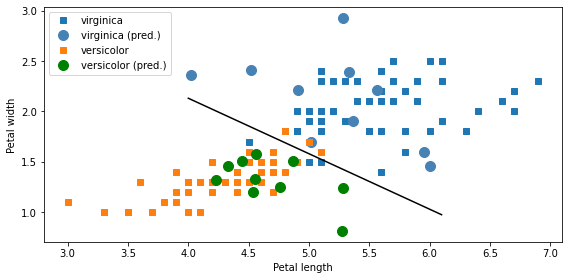

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.plot(df_subset[df_subset.Species == 0].Petal_Length.values,
        df_subset[df_subset.Species == 0].Petal_Width.values, 's', label='virginica')
ax.plot(df_new[df_new.Species == 0].Petal_Length.values,
        df_new[df_new.Species == 0].Petal_Width.values,
        'o', markersize=10, color="steelblue", label='virginica (pred.)')

ax.plot(df_subset[df_subset.Species == 1].Petal_Length.values,
        df_subset[df_subset.Species == 1].Petal_Width.values, 's', label='versicolor')
ax.plot(df_new[df_new.Species == 1].Petal_Length.values,
        df_new[df_new.Species == 1].Petal_Width.values,
        'o', markersize=10, color="green", label='versicolor (pred.)')

_x = np.array([4.0, 6.1])
ax.plot(_x, beta0 + beta1 * _x, 'k')

ax.set_xlabel('Petal length')
ax.set_ylabel('Petal width')
ax.legend(loc=2)
fig.tight_layout()


## Poisson Model


The [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) describes a process where the discrete (0,1,2,...) dependent variable counts the number of occurrences (0, 1, 2, ...) per unit time (or space) for a process that has a low constant probability of occuring.  A constant rate also implies that the model assumes occurrences are independent.

The parameter that needs estimating is the rate (number of occurrences per unit time) which is often called $\lambda$ (lambda).

Briefly look at the Wikipedia page (above link).


**Example:** Consider 'discoveries' dataset which contains counts of the number of great discoveries between 1860 to 1959:

In [35]:
# load the dataset from the R dataset repository
dataset = sm.datasets.get_rdataset("discoveries")
dataset.data.head()

,time,value
0,1860,5
1,1861,3
2,1862,0
3,1863,2
4,1864,0


In [36]:
dataset.data.info()
dataset.data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   time    100 non-null    int64
 1   value   100 non-null    int64
dtypes: int64(2)
memory usage: 1.7 KB


,time,value
count,100.000000,100.000000
mean,1909.500000,3.100000
std,29.011492,2.254065
min,1860.000000,0.000000
25%,1884.750000,2.000000
50%,1909.500000,3.000000
75%,1934.250000,4.000000
max,1959.000000,12.000000


In [37]:
# create a DataFrame with index "time"
df = dataset.data.set_index("time")
df

,value
time,
1860,5
1861,3
1862,0
1863,2
1864,0
...,...
1955,1
1956,0
1957,0


In [38]:
# rename the column name "value" to "discoveries" for reability
df.rename(columns={"value": "discoveries"}, inplace=True)
df.head()

,discoveries
time,
1860,5
1861,3
1862,0
1863,2
1864,0


Let's take a look at the data --- a bar chart or histogram seems appropriate for this type of data

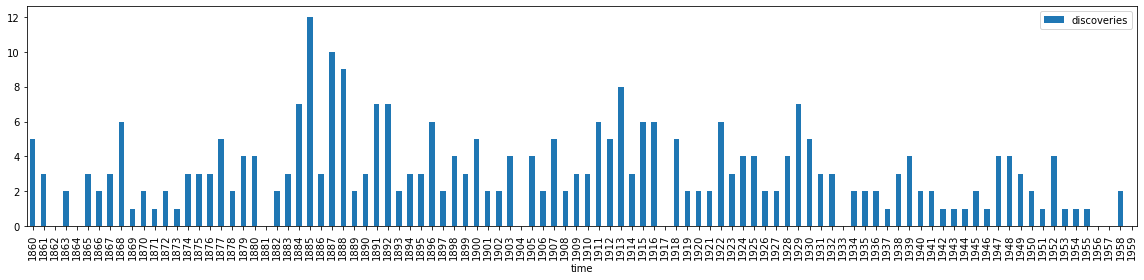

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
df.plot(kind='bar', ax=ax)
fig.tight_layout()

We have the hypothesis that the number of discoveries is [Poisson distributed](https://en.wikipedia.org/wiki/Poisson_distribution). Let's check this hypothesis.

Documentation for the statsmodel Poisson model is [here](https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.Poisson.html#statsmodels.discrete.discrete_model.Poisson).

In [40]:
# make the model
model = smf.poisson("discoveries ~ 1", data = df)

In [41]:
# fit
result = model.fit()

Optimization terminated successfully.
         Current function value: 2.168457
         Iterations 1


In [42]:
# print summary
print(result.summary())

                          Poisson Regression Results                          
Dep. Variable:            discoveries   No. Observations:                  100
Model:                        Poisson   Df Residuals:                       99
Method:                           MLE   Df Model:                            0
Date:                Mon, 21 Mar 2022   Pseudo R-squ.:                   0.000
Time:                        11:20:36   Log-Likelihood:                -216.85
converged:                       True   LL-Null:                       -216.85
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1314      0.057     19.920      0.000       1.020       1.243


In [43]:
# Or a little more detail
print(result.summary2())

                       Results: Poisson
Model:              Poisson          Pseudo R-squared: 0.000   
Dependent Variable: discoveries      AIC:              435.6913
Date:               2022-03-21 11:20 BIC:              438.2965
No. Observations:   100              Log-Likelihood:   -216.85 
Df Model:           0                LL-Null:          -216.85 
Df Residuals:       99               LLR p-value:      nan     
Converged:          1.0000           Scale:            1.0000  
No. Iterations:     1.0000                                     
----------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|   [0.025  0.975]
----------------------------------------------------------------
Intercept      1.1314    0.0568  19.9204  0.0000  1.0201  1.2427



The $\lambda$ parameter of the [Poisson](https://en.wikipedia.org/wiki/Poisson_distribution) distribution can be calculated from the model parameter:

(note that lambda is a reserved keyword in Python, so cannot use that)

In [44]:
lmbda = np.exp(result.params)
print(lmbda)

Intercept    3.1
dtype: float64


The standard error (deviation) enables us to construct an interval for $\lambda$ in which we have 95% (or pick your own value) confidence that the values should correspond. 
* 95% corresponds to $\pm$1.96 standard deviations.  

For the intercept the confidence interval is computed by hand as follows (values also provided in the table above)

In [45]:
# compute by hand
1.1314-1.96*0.0568 , 1.1314+1.96*0.0568

(1.0200719999999999, 1.242728)

To make it easier, the statsmodel package provides a routine

In [46]:
# use result.conf_int
result.conf_int().values

array([[1.02008364, 1.24272059]])

In [47]:
# Turn the confidence interval for the intercept into an interval for the predicted value of lambda
import math
lmbda_lo = math.exp(result.conf_int().values[0,0])
lmbda_hi = math.exp(result.conf_int().values[0,1])
print(lmbda_lo, lmbda_hi)


2.7734267167948614 3.465027556634305


The counts predicted by this model can now be obtained from the Scipy `stats` library:

First construct a Poisson model with the given $\lambda$

In [48]:
X = stats.poisson(lmbda)

In [49]:
# Create models for the lower and upper bounds of the confidence interval 
X_ci_lo = stats.poisson(lmbda_lo)
X_ci_hi = stats.poisson(lmbda_hi)

The probability of $k$ events ocurring per unit time is called the probability mass function (the analog of probability distribution function for continuous distributions).

Now let's make a plot showing the probability mass function for
* the original data
* the fit computed with `lmbda`
* the fit computed with `lmbda_lo`
* the fit computed with `lmbda_hi`
The messy bit is configuring the bars to make all of the data visible at once

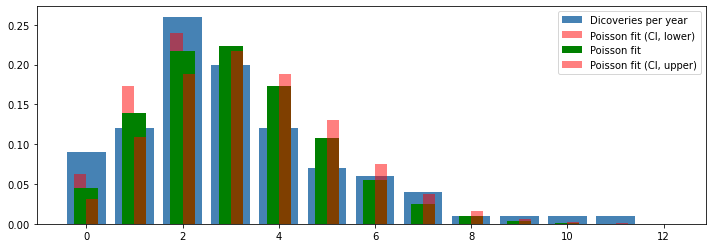

In [50]:
# Plot the histogram of the observed counts with the theoretical probablity mass functions 
v, k = np.histogram(df.values, bins=12, range=(0, 12), density=True)
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.bar(k[:-1], v, color="steelblue",  align='center', label='Dicoveries per year') 
ax.bar(k-0.125, X_ci_lo.pmf(k), color="red", alpha=0.5, align='center', width=0.25, label='Poisson fit (CI, lower)')
ax.bar(k, X.pmf(k), color="green",  align='center', width=0.5, label='Poisson fit')
ax.bar(k+0.125, X_ci_hi.pmf(k), color="red",  alpha=0.5, align='center', width=0.25, label='Poisson fit (CI, upper)')

ax.legend()
#fig.tight_layout()


As can be seen, the Poisson model seems to predict the overall shape and trends.

However, for multiple values of $k$ the observed counts lie outside the 95% confidence intervals --- the theoretical Poisson probabilty mass functions do not agree well in detail. Thus, we should reject the hypothesis that the discoveries are Poisson distributed. A possible reason why this data is not Poisson distributed is that years with a large and small number of discoveries tend to be clustered --- i.e., the events are correlated for some reason (economic/social events, one bright person, chains of ideas, ...). To make this decision (reject the model) more rigorous we could apply a $\chi^2$-test, but that is beyond the scope of this class.

## References: 
- *Numerical Python: A Practical Techniques Approach for Industry*  by Robert Johansson (Chapter 14)